# This notebook illustrates how to extract images and tables using `azure-ai-documentintelligence`. It also converts the extracted tables into images, making them easier for the LLM to understand.

In [ ]:
! pip install python-dotenv openai azure-ai-documentintelligence azure-identity pillow PyMuPDF

In [ ]:
from PIL import Image
import fitz  # PyMuPDF
import mimetypes
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient

In [ ]:
pdf_file = "sample-doc.pdf"

In [ ]:
def crop_image_from_image(image_path, page_number, bounding_box):
    """
    Crops an image based on a bounding box.

    :param image_path: Path to the image file.
    :param page_number: The page number of the image to crop (for TIFF format).
    :param bounding_box: A tuple of (left, upper, right, lower) coordinates for the bounding box.
    :return: A cropped image.
    :rtype: PIL.Image.Image
    """
    with Image.open(image_path) as img:
        if img.format == "TIFF":
            # Open the TIFF image
            img.seek(page_number)
            img = img.copy()

        # The bounding box is expected to be in the format (left, upper, right, lower).
        cropped_image = img.crop(bounding_box)
        return cropped_image

def crop_image_from_pdf_page(pdf_path, page_number, bounding_box):
    """
    Crops a region from a given page in a PDF and returns it as an image.

    :param pdf_path: Path to the PDF file.
    :param page_number: The page number to crop from (0-indexed).
    :param bounding_box: A tuple of (x0, y0, x1, y1) coordinates for the bounding box.
    :return: A PIL Image of the cropped area.
    """
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)

    # Cropping the page. The rect requires the coordinates in the format (x0, y0, x1, y1).
    bbx = [x * 72 for x in bounding_box]
    rect = fitz.Rect(bbx)
    pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72), clip=rect)

    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    doc.close()

    return img

def crop_image_from_file(file_path, page_number, bounding_box):
    """
    Crop an image from a file.

    Args:
        file_path (str): The path to the file.
        page_number (int): The page number (for PDF and TIFF files, 0-indexed).
        bounding_box (tuple): The bounding box coordinates in the format (x0, y0, x1, y1).

    Returns:
        A PIL Image of the cropped area.
    """
    mime_type = mimetypes.guess_type(file_path)[0]

    if mime_type == "application/pdf":
        return crop_image_from_pdf_page(file_path, page_number, bounding_box)
    else:
        return crop_image_from_image(file_path, page_number, bounding_box)

My document analysis service is poor, so I analyze each page separately and save the results in the `old_analysis` file 🥲

In [ ]:
# import base64

# def analyze_layout(input_file_path):

    # document_intelligence_client = DocumentIntelligenceClient(
    #     endpoint="",
    #     credential=AzureKeyCredential(""),
    #     headers={"x-ms-useragent":"sample-code-figure-understanding/1.0.0"},
    # )

    # with open(input_file_path, "rb") as f:
    #     analyze_request = {
    #         "base64Source": base64.b64encode(f.read()).decode("utf-8")
    #     }
    #     poller = document_intelligence_client.begin_analyze_document(
    #         "prebuilt-layout",
    #          body=analyze_request,
    #          output_content_format="markdown"
    #     )

    # result = poller.result()

    # return result

from old_analysis import get_pre_analyze_page_0
from old_analysis import get_pre_analyze_page_1
from old_analysis import get_pre_analyze_page_2

In [ ]:
def get_tables(page_analysis):
    if 'tables' in page_analysis and page_analysis['tables']:
        tables = [x['boundingRegions'][0]['polygon'] for x in page_analysis['tables']]
        return tables

    return []

In [ ]:
def get_images(page_analysis):
    if 'figures' in page_analysis and page_analysis['figures']:
        images = [x['boundingRegions'][0]['polygon'] for x in page_analysis['figures']]
        return images

    return []

In [ ]:
def get_bbox(bounding_regions):
    return (
        bounding_regions[0],  # x0 (left)
        bounding_regions[1],  # y0 (top)
        bounding_regions[4],  # x1 (right)
        bounding_regions[5]   # y1 (bottom)
    )

In [ ]:
page_0 = get_pre_analyze_page_0()['analyzeResult']
page_1 = get_pre_analyze_page_1()['analyzeResult']
page_2 = get_pre_analyze_page_2()['analyzeResult']

Page 1


============================ Page #1 - Table #1 ============================


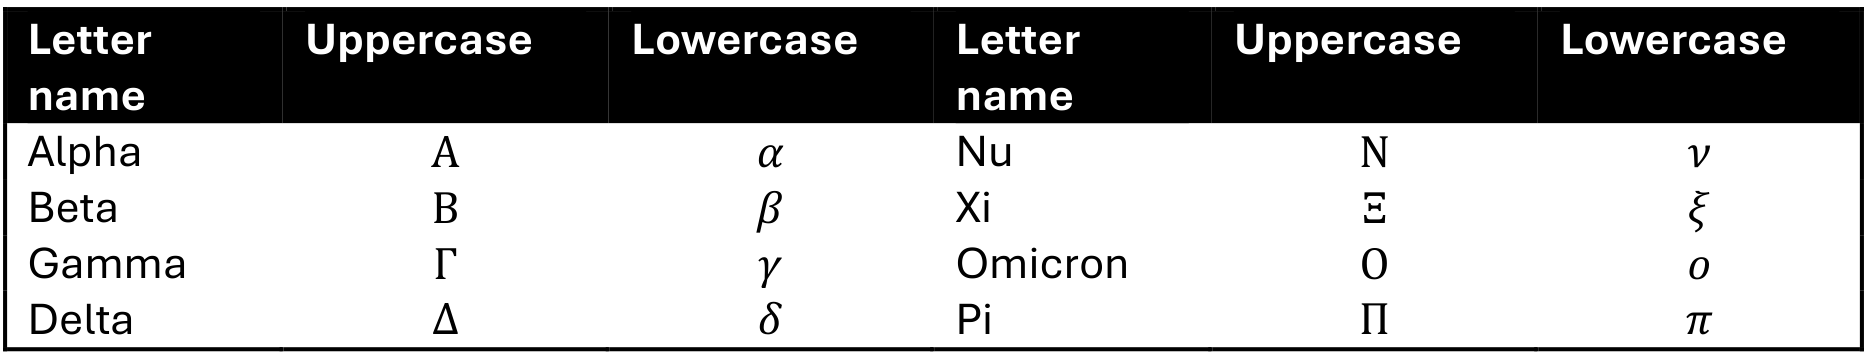



============================ Page #1 - Table #2 ============================


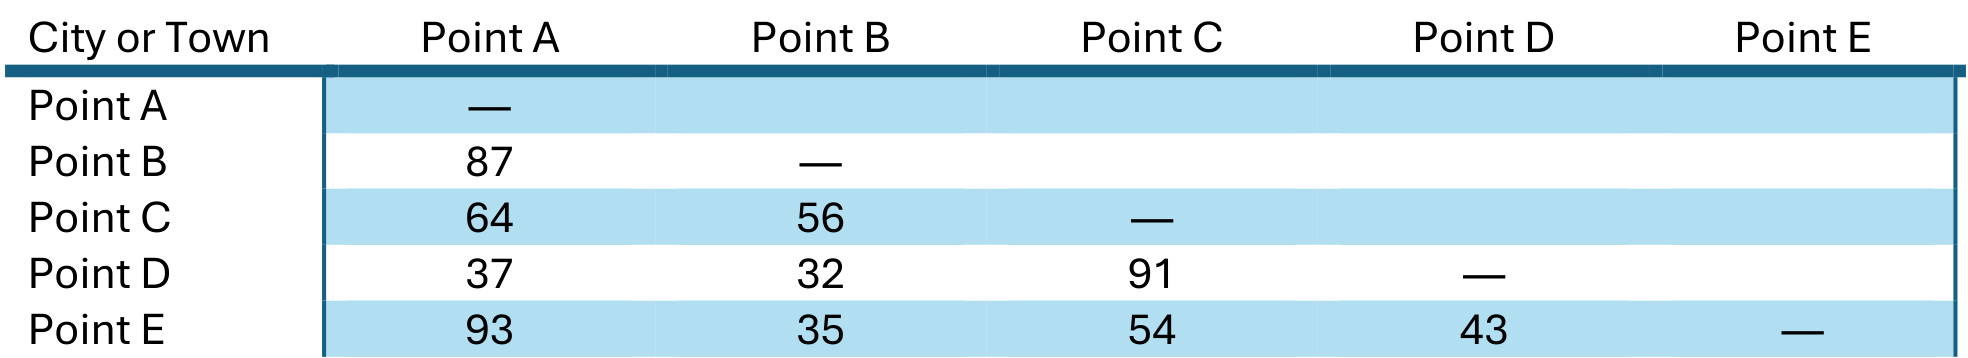



============================ Page #1 - Table #3 ============================


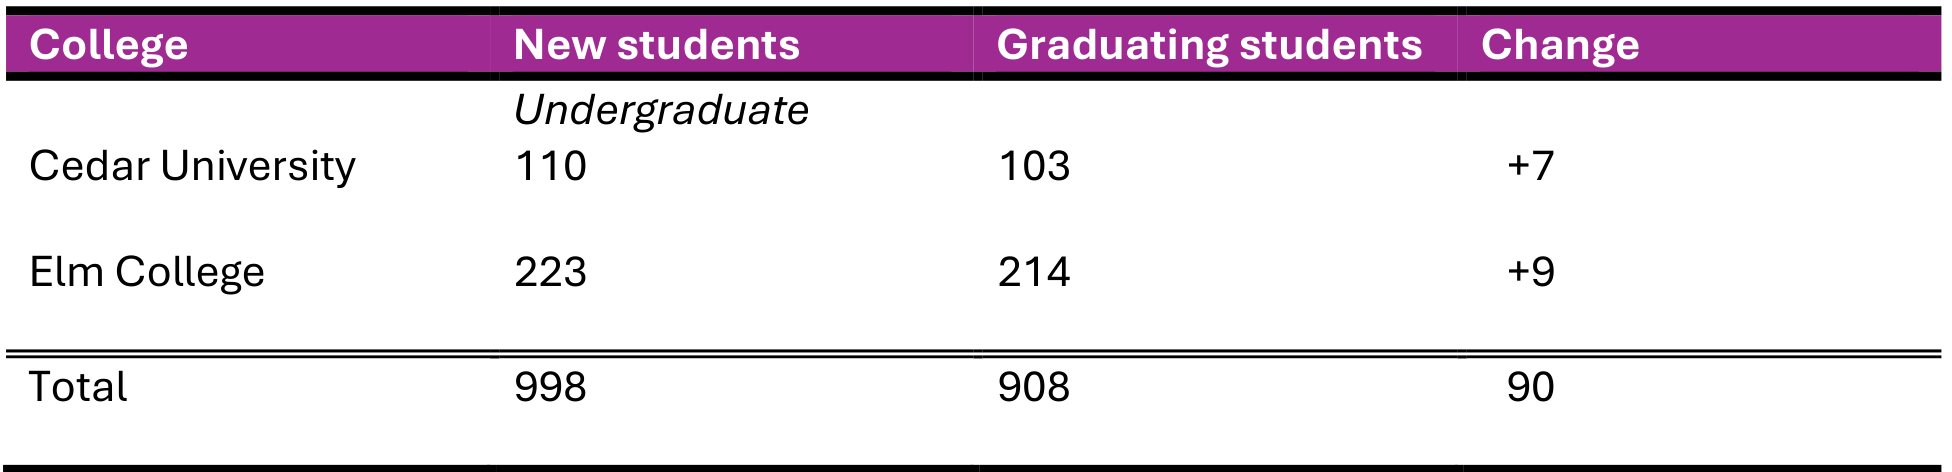

In [ ]:
page_0 = get_pre_analyze_page_0()['analyzeResult']
tables = get_tables(page_0)
images = get_images(page_0)

for t, table in enumerate(tables):
    print()
    print(f"============================ Page #1 - Table #{(1+t)} ============================")
    display(crop_image_from_file(pdf_file, 0, get_bbox(table)))
    print()

for i, image in enumerate(images):
    print()
    print(f"============================ Page #1 - Table #{(1+i)} ============================")
    display(crop_image_from_file(pdf_file, 0, get_bbox(image)))
    print()


Page 2


============================ Page #2 - Table #1 ============================


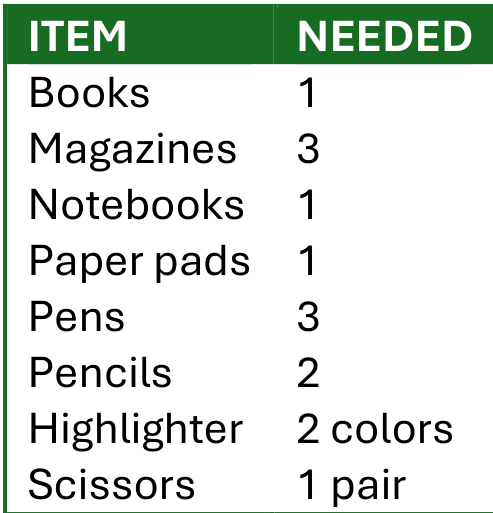



============================ Page #2 - Table #2 ============================


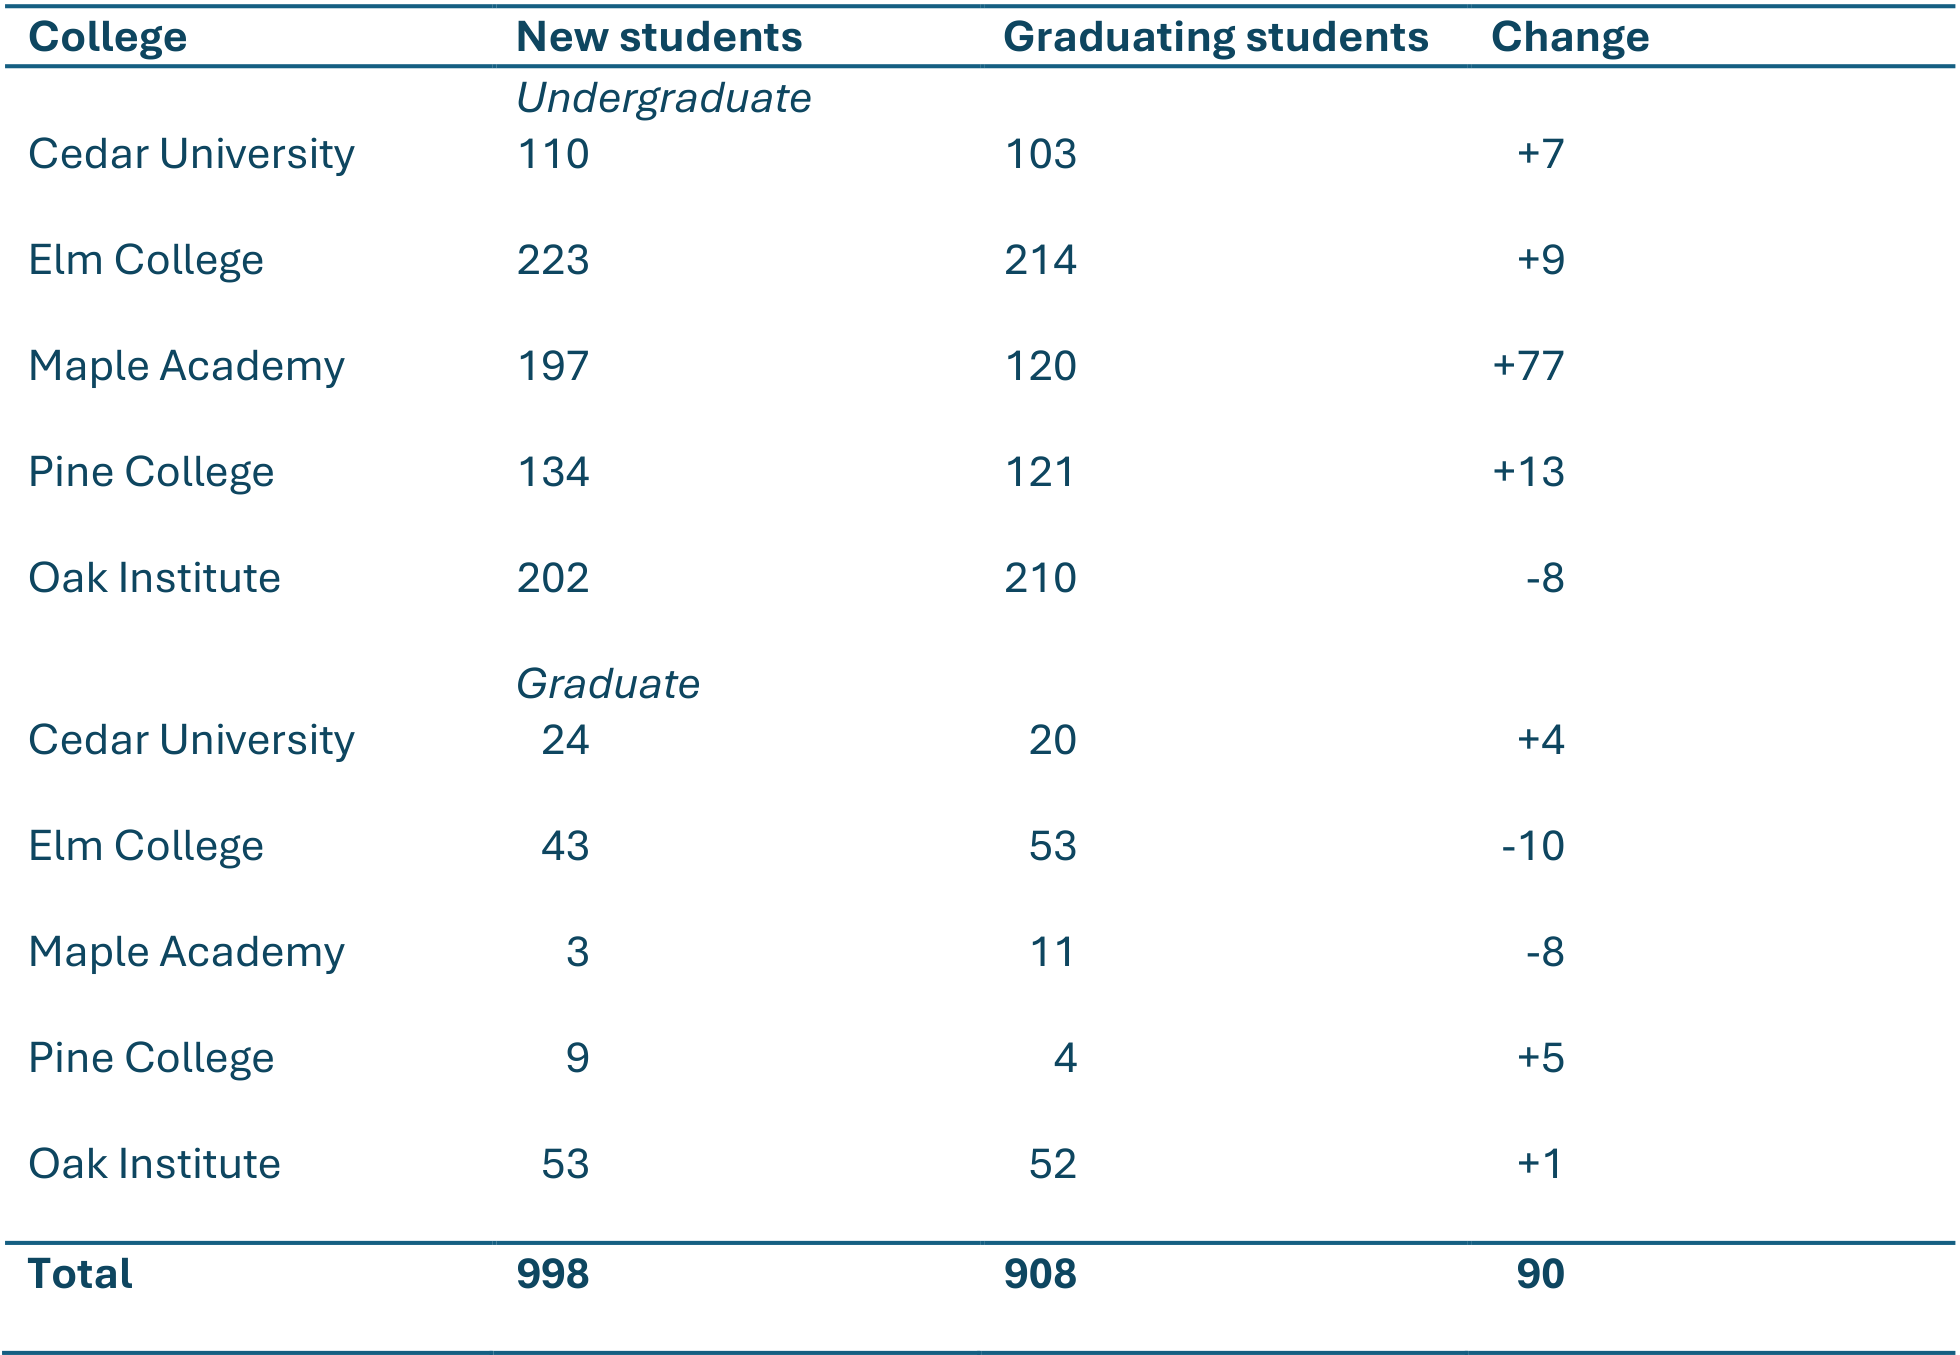

In [ ]:
page_1 = get_pre_analyze_page_1()['analyzeResult']
tables = get_tables(page_1)
images = get_images(page_1)

for t, table in enumerate(tables):
    print()
    print(f"============================ Page #2 - Table #{(1+t)} ============================")
    display(crop_image_from_file(pdf_file, 1, get_bbox(table)))
    print()

for i, image in enumerate(images):
    print()
    print(f"============================ Page #2 - Table #{(1+i)} ============================")
    display(crop_image_from_file(pdf_file, 1, get_bbox(image)))
    print()

Page 3


============================ Page #3 - Table #1 ============================


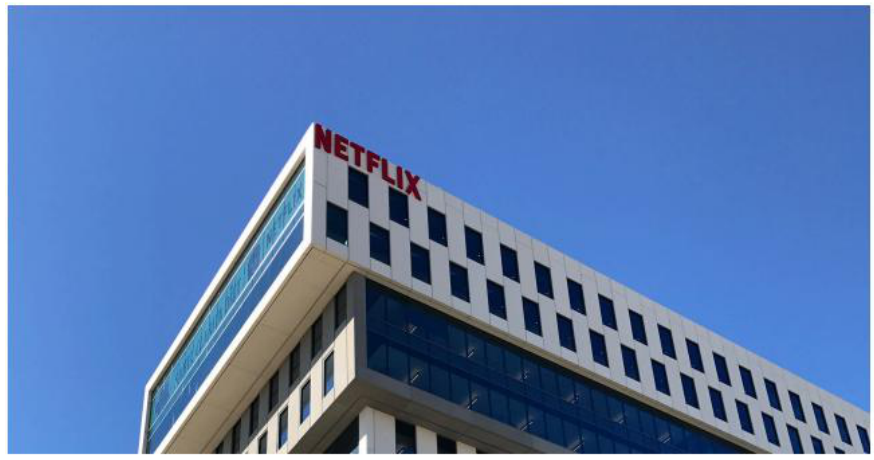



============================ Page #3 - Table #2 ============================


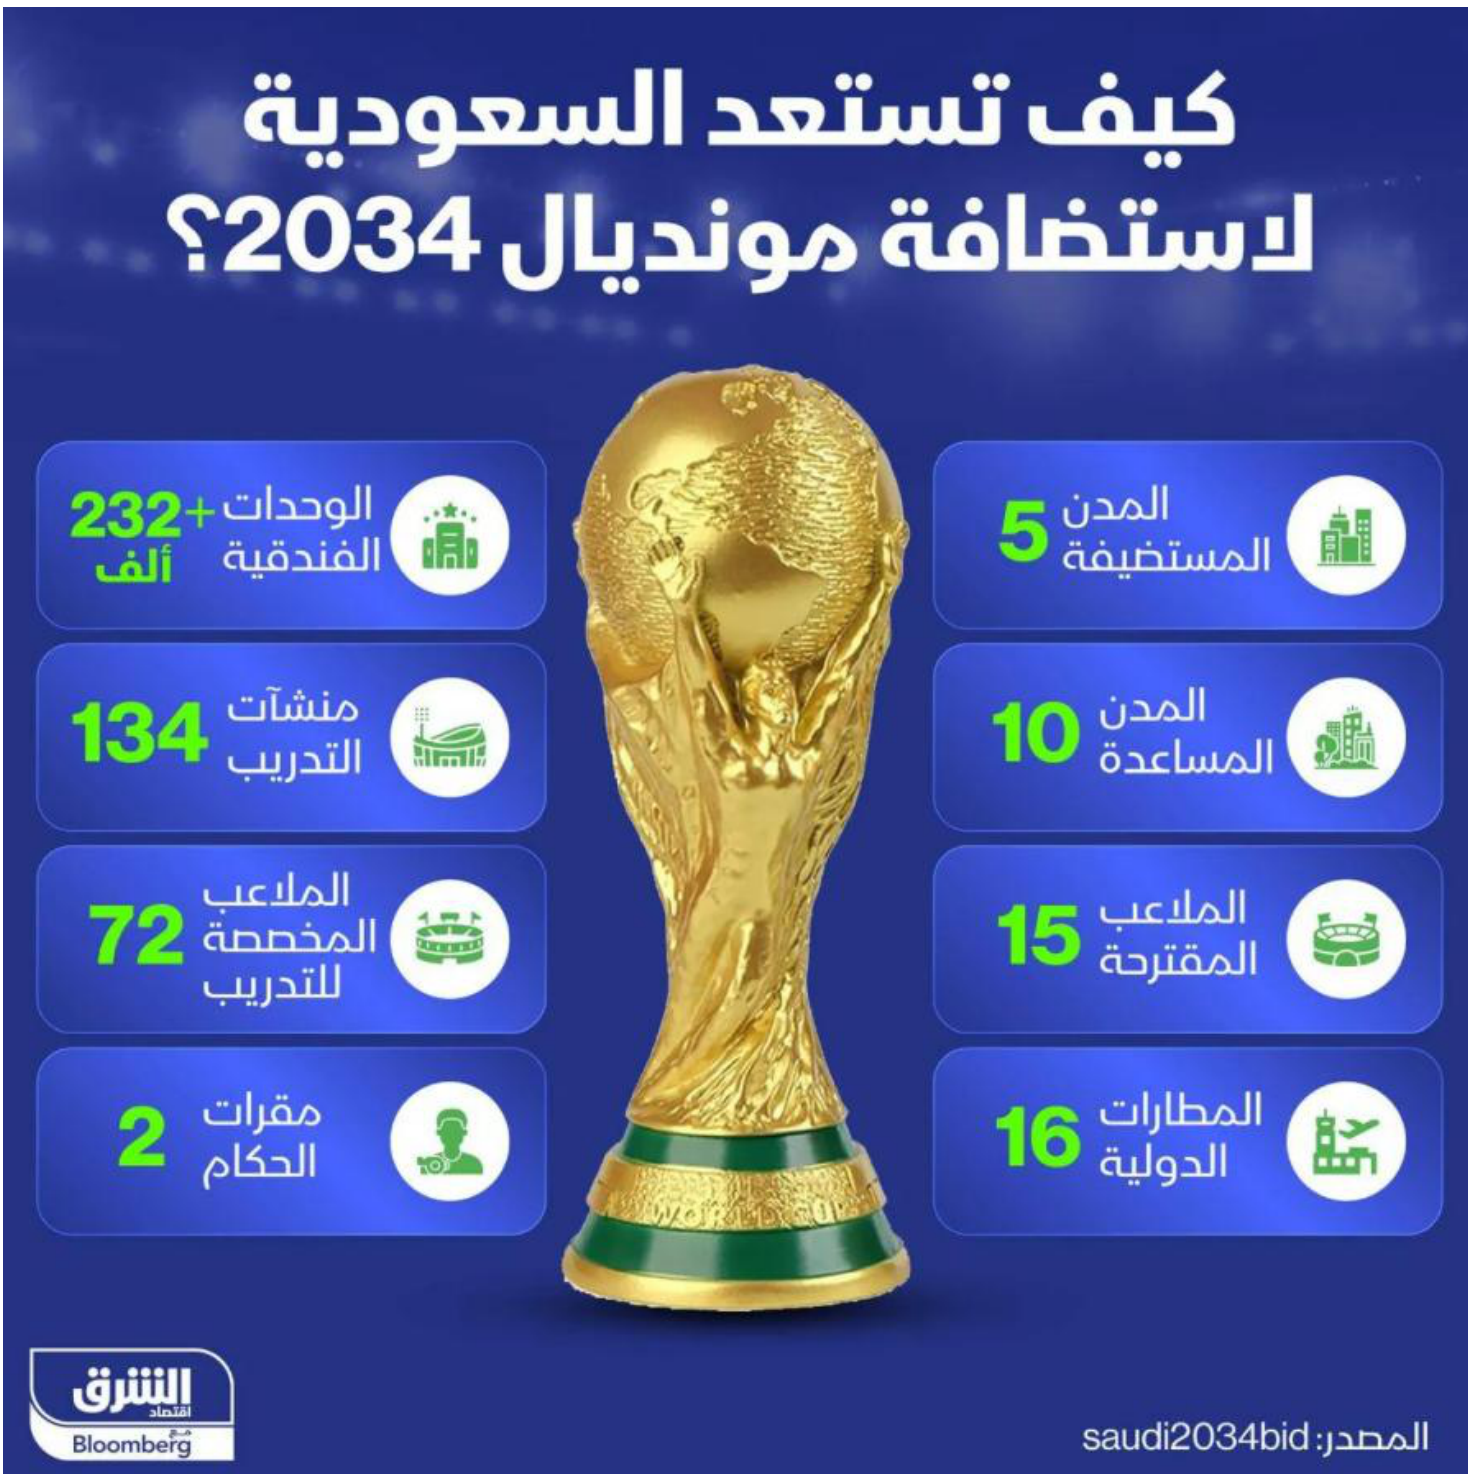

In [ ]:
page_2 = get_pre_analyze_page_2()['analyzeResult']
tables = get_tables(page_2)
images = get_images(page_2)

for t, table in enumerate(tables):
    print()
    print(f"============================ Page #3 - Table #{(1+t)} ============================")
    display(crop_image_from_file(pdf_file, 2, get_bbox(table)))
    print()

for i, image in enumerate(images):
    print()
    print(f"============================ Page #3 - Table #{(1+i)} ============================")
    display(crop_image_from_file(pdf_file, 2, get_bbox(image)))
    print()